In [ ]:
"""
Use a one v. rest approach to create a multiclass classifier from LASSO
Also try a dedicated multiclass classfier

Shaina Lu
Zador & Gillis Labs
April 2021
"""

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #stratify train/test split
import random

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# Read in Data and pre-processing

In [4]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"

In [5]:
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology


def getleaves(propontvox, ontology):
    """helper function to get only leaf brain areas"""
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    print("number of leaf areas: %d" %len(leaves))
    return leaves

def findoverlapareas(STonto, propontvox, ontology):
    """find leaf brain areas overlapping between the two datasets"""
    leafST = getleaves(STonto, ontology)
    leafABA = getleaves(propontvox, ontology)

    leafboth = [] 
    for i in range(len(leafABA)):
        if leafABA[i] in leafST:
            leafboth.append(leafABA[i])
    
    STonto = STonto.loc[:,leafboth]
    propontvox = propontvox.loc[:,leafboth]
    
    return STonto, propontvox    

def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score on whole data set before splitting into test and train
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label (ctxnotctx)
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels)
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox


In [6]:
def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 100] #100 to subset for dedicated multiclass
    
    return sampleonto

# Main

In [6]:
#CROSS

#read in data
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()

STmeta, STspots, STpropont = read_STdata()

#filter brain areas for those that have at least x samples
STpropont = filterproponto(STpropont)
ABApropont = filterproponto(ABApropont)
#filter brain areas for overlapping leaf areas
STpropont, ABApropont = findoverlapareas(STpropont, ABApropont, ontology)

#keep only genes that are overlapping between the two datasets
STspots, ABAvox = getoverlapgenes(STspots, ABAvox)

KeyboardInterrupt: 

In [7]:
#JUST ST
ontology = read_ontology()
#pre-processing
STspotsmeta, STspots, STpropont = read_STdata()
STpropont = filterproponto(STpropont)
STspots = STspots.astype('float64') #convert int to float for z-scoring
#get leaf areas
leaves = getleaves(STpropont, ontology)
STpropont = STpropont.loc[STspotsmeta.id.isin(leaves),leaves] #subset prop onto for leaf areas
STspots = STspots.loc[STspotsmeta.id.isin(leaves),:] #subset data for samples from leaves


number of leaf areas: 65


In [127]:
#JUST ABA
#read in data
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()
#pre-processing
ABApropont = filterproponto(ABApropont)
#get leaf ares only
leaves = getleaves(ABApropont,ontology)
ABApropont = ABApropont.loc[ABAmeta.ids.isin(leaves),leaves]
ABAvox = ABAvox.loc[ABAmeta.ids.isin(leaves),:]

number of leaf areas: 139


# OVR

In [12]:
def applyLASSO(Xtrain, Xtest, ytrain, ytest):
    """apply LASSO regression"""
    #lasso_reg = Lasso(alpha=0.01, max_iter=10000)
    lasso_reg = LinearRegression()
    lasso_reg.fit(Xtrain, ytrain)
    
    #train
    predictions_train = lasso_reg.predict(Xtrain)
    #auroc_train = analytical_auroc(sp.stats.mstats.rankdata(predictions_train), ytrain)
    #test
    predictions_test = lasso_reg.predict(Xtest)
    #auroc_test = analytical_auroc(sp.stats.mstats.rankdata(predictions_test), ytest)
    
    return sp.stats.mstats.rankdata(predictions_train), sp.stats.mstats.rankdata(predictions_test)

In [ ]:
mod_propont = leafSTpropont
mod_data = leafSTspots
#cross_propont = ABApropont
#cross_data = ABAvox

trainpreds = pd.DataFrame(columns=list(mod_propont))
testpreds = pd.DataFrame(columns=list(mod_propont))
    
areas = list(mod_propont)
#for each column, brain area
for i in range(mod_propont.shape[1]):
    print("col %d" %i)
    area1 = areas[i]

    #get binary label vectors
    ylabels = mod_propont.loc[:, area1]

    #split train test for X data and y labels
    #split data function is seeded so all will split the same way
    Xtrain, Xtest, ytrain, ytest = train_test_split(mod_data, ylabels, test_size=0.5,\
                                                    random_state=42, shuffle=True,\
                                                    stratify=ylabels)
    #z-score train and test folds
    zXtrain = zscore(Xtrain)
    zXtest = zscore(Xtest)

    #fit LASSO on train set for 1 v all
    currpred_train,currpred_test = applyLASSO(zXtrain, zXtest, ytrain, ytest)
    #key = "%s,%s" %(str(i))
    trainpreds[area1] = currpred_train
    testpreds[area1] = currpred_test
    #break

col 0
col 1
col 2
col 3
col 4
col 5


In [ ]:
trainpreds.to_csv("trainpreds_040321.csv", sep=',',header=True,index=False)
testpreds.to_csv("testpreds_040321.csv", sep=',',header=True,index=False)

In [42]:
trainpreds = pd.read_csv("trainpreds_040321.csv", sep=',')
testpreds = pd.read_csv("testpreds_040321.csv", sep=',')

In [59]:
#rank rows
trainranks = sp.stats.mstats.rankdata(trainpreds.to_numpy(),axis=1)
testranks = sp.stats.mstats.rankdata(testpreds.to_numpy(),axis=1)

#convert back to pandas
trainranks = pd.DataFrame(trainranks, index=trainpreds.index, columns=trainpreds.columns)
testranks = pd.DataFrame(testranks, index=testpreds.index, columns=testpreds.columns)

In [ ]:
#get aurocs
trainauroc = {}
testauroc = {}

areas = list(mod_propont)
#for each column, brain area
for i in range(mod_propont.shape[1]):
    if i %5 == 0:
        print("col %d" %i)
    area1 = areas[i]

    #get binary label vectors
    ylabels = mod_propont.loc[:, area1]

    #split train test for X data and y labels
    #split data function is seeded so all will split the same way
    Xtrain, Xtest, ytrain, ytest = train_test_split(mod_data, ylabels, test_size=0.5,\
                                                    random_state=42, shuffle=True,\
                                                    stratify=ylabels)

    #get auroc of new prediction vector
    trainauroc[area1] = analytical_auroc(sp.stats.mstats.rankdata(trainranks[area1]), ytrain)
    testauroc[area1] = analytical_auroc(sp.stats.mstats.rankdata(testranks[area1]), ytest)

col 0
col 5
col 10
col 15
col 20
col 25
col 30
col 35
col 40
col 45
col 50
col 55
col 60
col 65
col 70
col 75
col 80
col 85
col 90
col 95
col 100
col 105
col 110
col 115
col 120
col 125
col 130
col 135
col 140
col 145
col 150
col 155
col 160
col 165
col 170
col 175
col 180
col 185
col 190
col 195
col 200
col 205
col 210
col 215
col 220
col 225
col 230
col 235
col 240
col 245
col 250
col 255
col 260
col 265
col 270
col 275
col 280
col 285
col 290
col 295
col 300
col 305
col 310
col 315
col 320
col 325
col 330
col 335
col 340
col 345
col 350
col 355
col 360
col 365
col 370
col 375


In [84]:
plt.hist(trainauroc.values())
plt.xlabel("ST train AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.98,120,"mean = %.3f" %np.mean(list(trainauroc.values())))
plt.savefig("040521_1.pdf", bbox_inches='tight')
plt.show()

print(np.mean(list(trainauroc.values())))

NameError: name 'trainauroc' is not defined

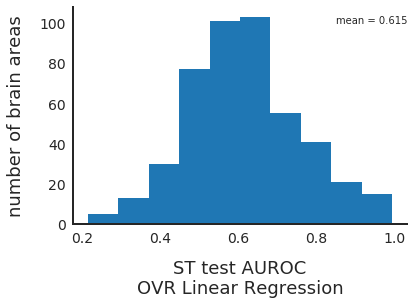

0.6154376588641873


In [120]:
plt.hist(testauroc.values())
plt.xlabel("ST test AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.85,100,"mean = %.3f" %np.mean(list(testauroc.values())))
plt.savefig("040521_2.pdf", bbox_inches='tight')
plt.show()

print(sp.mean(list(testauroc.values())))

# Dedicated multiclass classifier: KNN
# ST

only for 65 brain areas>100 for speed of running

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
#collapse STpropont so I can use it to stratify train/test split
columns = STpropont.columns
ycollapse = pd.Series(index = STpropont.index)
for i in range(len(columns)):
    currrows = np.where(STpropont[columns[i]] == 1.0)[0]
    ycollapse.iloc[currrows] = columns[i]

In [13]:
#to get single y vector split
Xtrain, Xtest, ytrain, ytest = train_test_split(STspots, ycollapse, test_size=0.5,\
                                                    random_state=42, shuffle=True,\
                                                    stratify=ycollapse)

In [79]:
#to get propont split on the same indicies
null1, null2, ytrain2, ytest2 = train_test_split(STspots, STpropont, test_size=0.5,\
                                                    random_state=42, shuffle=True,\
                                                    stratify=ycollapse)

In [14]:
#z-score
zXtrain = zscore(Xtrain)
zXtest = zscore(Xtest)

In [15]:
model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=-1)
model.fit(zXtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [20]:
accuracy = model.score(zXtest.iloc[0:10,:], ytest.iloc[0:10])

In [21]:
accuracy

0.1

In [23]:
testpreds = model.predict(zXtest)

In [107]:
#break predictions vector out
testpredmatrix = pd.DataFrame(0, index=(range(len(testpreds))), columns = STpropont.columns)
for i in range(len(testpredmatrix.columns)):
    area = testpredmatrix.columns[i]
    for j in range(len(testpreds)):
        if testpreds[j] == area:
            testpredmatrix.iloc[j,i] = 1

In [108]:
testaurocs = []
for col in testpredmatrix.columns:
    testaurocs.append(analytical_auroc(sp.stats.mstats.rankdata(testpredmatrix.loc[:,col]),ytest2.loc[:,col]))

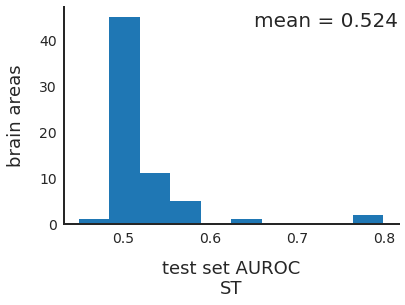

In [175]:
plt.hist(testaurocs)
plt.xlabel("test set AUROC\nST")
plt.ylabel("brain areas")
plt.text(0.65, 43, "mean = %.3f" %np.mean(testaurocs),size=20)
plt.savefig("051021_1.pdf", bbox_inches='tight')
plt.show()

In [118]:
trainpreds = model.predict(zXtrain)

In [119]:
#break predictions vector out
trainpredmatrix = pd.DataFrame(0, index=(range(len(trainpreds))), columns = STpropont.columns)
for i in range(len(trainpredmatrix.columns)):
    area = trainpredmatrix.columns[i]
    for j in range(len(trainpreds)):
        if trainpreds[j] == area:
            trainpredmatrix.iloc[j,i] = 1

In [120]:
trainaurocs = []
for col in trainpredmatrix.columns:
    trainaurocs.append(analytical_auroc(sp.stats.mstats.rankdata(trainpredmatrix.loc[:,col]),ytrain2.loc[:,col]))

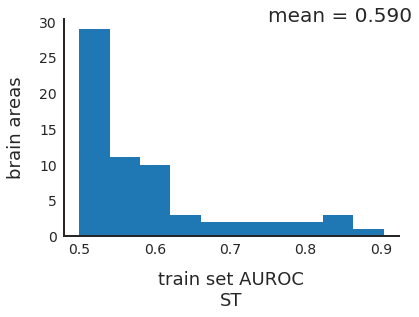

In [173]:
plt.hist(trainaurocs)
plt.xlabel("train set AUROC\nST")
plt.ylabel("brain areas")
plt.text(0.75, 30, "mean = %.3f" %np.mean(trainaurocs),size=20)
plt.savefig("051021_2.pdf", bbox_inches='tight')
plt.show()

# ABA

only for 139 brain areas>100 for speed of running

In [128]:
#collapse ABApropont so I can use it to stratify train/test split
columns = ABApropont.columns
ycollapse = pd.Series(index = ABApropont.index)
for i in range(len(columns)):
    currrows = np.where(ABApropont[columns[i]] == 1.0)[0]
    ycollapse.iloc[currrows] = columns[i]

In [129]:
#to get single y vector split
Xtrain, Xtest, ytrain, ytest = train_test_split(ABAvox, ycollapse, test_size=0.5,\
                                                    random_state=42, shuffle=True,\
                                                    stratify=ycollapse)

In [130]:
#to get propont split on the same indicies
null1, null2, ytrain2, ytest2 = train_test_split(ABAvox, ABApropont, test_size=0.5,\
                                                    random_state=42, shuffle=True,\
                                                    stratify=ycollapse)

In [133]:
#z-score
zXtrain = zscore(Xtrain)
zXtest = zscore(Xtest)

In [134]:
model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=-1)
model.fit(zXtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [135]:
testpreds = model.predict(zXtest)

In [136]:
#break predictions vector out
ABAtestpredmatrix = pd.DataFrame(0, index=(range(len(testpreds))), columns = ABApropont.columns)
for i in range(len(ABAtestpredmatrix.columns)):
    area = ABAtestpredmatrix.columns[i]
    for j in range(len(testpreds)):
        if testpreds[j] == area:
            ABAtestpredmatrix.iloc[j,i] = 1

In [137]:
ABAtestaurocs = []
for col in ABAtestpredmatrix.columns:
    ABAtestaurocs.append(analytical_auroc(sp.stats.mstats.rankdata(ABAtestpredmatrix.loc[:,col]),ytest2.loc[:,col]))

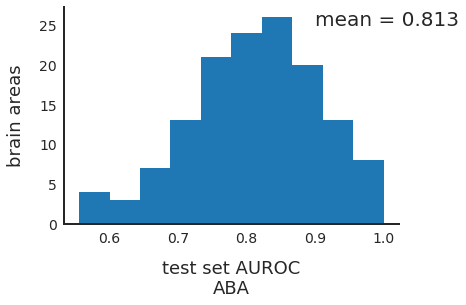

In [140]:
plt.hist(ABAtestaurocs)
plt.xlabel("test set AUROC\nABA")
plt.ylabel("brain areas")
plt.text(0.9, 25, "mean = %.3f" %np.mean(ABAtestaurocs),size=20)
plt.savefig("051021_3.pdf", bbox_inches='tight')
plt.show()

In [ ]:
ABAtrainpreds = model.predict(zXtrain)

In [164]:
#break predictions vector out
ABAtrainpredmatrix = pd.DataFrame(0, index=(range(len(ABAtrainpreds))), columns = ABApropont.columns)
for i in range(len(ABAtrainpredmatrix.columns)):
    area = ABAtrainpredmatrix.columns[i]
    for j in range(len(ABAtrainpreds)):
        if ABAtrainpreds[j] == area:
            ABAtrainpredmatrix.iloc[j,i] = 1

In [166]:
ABAtrainaurocs = []
for col in ABAtrainpredmatrix.columns:
    ABAtrainaurocs.append(analytical_auroc(sp.stats.mstats.rankdata(ABAtrainpredmatrix.loc[:,col]),ytrain2.loc[:,col]))

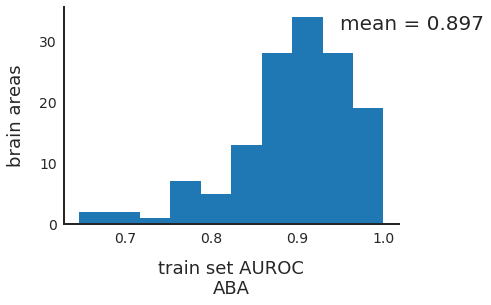

In [171]:
plt.hist(ABAtrainaurocs)
plt.xlabel("train set AUROC\nABA")
plt.ylabel("brain areas")
plt.text(0.95, 32, "mean = %.3f" %np.mean(ABAtrainaurocs),size=20)
plt.savefig("051021_4.pdf", bbox_inches='tight')
plt.show()